## Group Assignment
### Team Number: 05
### Team Member Names: Piero Camposeo, Sathun Suthakaran, Ishaan Bansal
### Team Strategy Chosen: SAFE

## Overview:

We want to generate an unusually "safe" portfolio. Rather than maximize returns, we want to keep returns as close as possible to zero. The goal is to generate a portfolio, based on a random set of tickers, whose projected value over an arbitrary number of days is as close to its starting value as possible. Specifically, our code is made for a 5-day run-time of the portfolio, but the model used is viable for any period of time (though it is often not preferred).

The code is split into three sections:

1. DATA CLEANING
2. CHOOSING THE STOCKS
3. CREATING THE PORTFOLIO

Data cleaning involves removing tickers that do not fit a certain criteria, chosen by the user.

Choosing the stocks involves picking the least volatile tickers, which we will utilize in our final portfolio.

Creating the portfolio involves generating randomly weighted portfolios, comprised of our tickers. The final portfolio will be that which has the expected return closest to 0. We will calculate expected return based on a <b>modified, Multi-Security Capital Asset Pricing Model</b> (below).

![Modified, Multi-Security CAPM](Pricing-Model-Image.png)

The code should output the final .......****************

In [75]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import threading
import time
from queue import Queue
import random
from random import uniform

In [76]:
#Read in csv file of tickers
csv_file = "Tickers.csv"

# Make values into a list
tickers = pd.read_csv(csv_file)
ticker_list = tickers.iloc[:, 0].values.tolist()
ticker_list.insert(0, tickers.columns[0])

In [77]:
#Consumes desired amount of trading days within a month, a dataframe of days, a dstaframe of months, and a list of months that cooresponds to the months
#    on the dataframe, outputs the monthly dataframe with only months that have 'daycount' amount of trading days for that stock
#Note: Function will cover up to the last date. For example, the function will not produce October for a dataframe which ends on October 1st.
#   In our code, we simply passed a days dataframe that ends one month after the months dataframe does (*)
def df_with_valid_months(daycount, df_days, df_months, months):
    for month in range (len(months)):
        if len(df_days.filter(like = months[month], axis = 0)) < daycount:
            df_months.drop(df_months.index[month], axis = 0, inplace = True) #Drop any months with not enough trading days
            
    return(df_months)

#Consumes historical data for a stock, outputs average volume
def average_volume(df_hist):
    volume = df_hist['Volume'].dropna().values.tolist()
    vol_av = np.mean(volume)

    return(vol_av)


## 1. DATA CLEANING: 

This cell is where the data cleaning happens.

THE GOAL:

•	Ignore any tickers that do not reference a valid stock denominated in USD, i.e., only use US listed stocks.

•	Use only tickers that reference stocks which have an average monthly volume of at least 200,000 shares, as calculated based on the time interval of January 01, 2022 to October 31, 2022. A month is defined as a calendar month. We will drop any month that does not have at least 20 trading days.

THE PROCESS:

Firstly, we have chosen to implement multithreading, in order to speed up the process. The data cleaning is the most time-consuming code in the program to run. Due to this, we have two main functions (currency_check and volume_check), running on two seperate threads, c and v. These functions are defined recursively; If too many tickers are passed into the function (i.e a list of tickers that is longer than the 'max_length_lst' variable in each function), the function calls on a number of threads to run the function with smaller, sublists. When a small enough quantity of tickers is passed to the function, it will perform the criteria check for the tickers. Valid tickers get passed to the function's respective queue. Finally, the queue is cleared, and tickers that fit both criterion are outputted and saved as our tickers.

Note 1: Currency check generates more threads per application than volume_check because it takes significantly longer to run. This is also why its 'max_list_length' variable is smaller

Note 2: For the sake of comparison, when tested by our team:

- Unthreaded, non-recursive code takes ~13 minutes to run
- Multithreaded, non-recursive code takes ~5-10 minutes to run
- <b>Multithreaded, recursive code takes ~1 minute to run</b>

Note 3: 'max_length_lst' may need to be updates for larger lists of tickers

Our code checks each of the two criterion mentioned in the goal (one for each function), and helps to generate two lists. Each list contains tickers which reference stocks that have satisfied the criteria of the functions. As we want stocks that fit both criterion, our final list of (valid) tickers is the set intersection of the two lists which each function produces.


In [78]:
#dates for volume calculation, end date for valid months function (see (*))
vol_date_s = '2022-01-01'
vol_date_e = '2022-10-02'
endDForValidMonthsFunct = str((pd.to_datetime(vol_date_e) + relativedelta(months = 1)).strftime("%Y-%m-%d"))

#for df_with_valid_months function, creates a series of months from vol_date_s to vol_date_e
months = pd.date_range(vol_date_s, vol_date_e, freq='MS').strftime("%Y-%m").tolist()

#As outlined in assignment information
minimumMonthlyTradingDays = 20
minimum_volume = 200000
required_denomination = 'USD'

#Here we will put valid stocks that fit our criteria
tickers = []

currency_valid = []
volume_valid = []

#Queue variables to store tickers
queueC = Queue()
queueV = Queue()

#Consumes a list of tickers, used to check if they are denominated in 'required_denomination'.
def currency_check(ticker_list):
    max_length_lst = 5

    #When there are an appropriate number of tickers in ticker_list, the function performs currency_check
    if len(ticker_list) <= max_length_lst:

        #Retrieve financial currency from each ticker. If it is 'required_denomination', it is a valid ticker. Else, we don't care so we set it as nan
        for ticker in ticker_list:
            tick = yf.Ticker(ticker)
            try:
                currency = tick.info['currency']
            except:
                currency = 'nan'
        
            #Check criteria, add to list of valid tickers for currency
            if currency == required_denomination:
                #Pass our valid tickers to the QueueC (Queue Currency), so that they may be called on later
                queueC.put(ticker)

    #If there are too many tickers in ticker_lst, we run a recursive application of currency_check with five threads, with the arguments being one of
    #Five equal parts of ticker_list  
    else:
        ticker_split = np.array_split(ticker_list, 5)

        cSub1 = threading.Thread(target = currency_check, args = (ticker_split[0],))
        cSub2 = threading.Thread(target = currency_check, args = (ticker_split[1],))
        cSub3 = threading.Thread(target = currency_check, args = (ticker_split[2],))
        cSub4 = threading.Thread(target = currency_check, args = (ticker_split[3],))
        cSub5 = threading.Thread(target = currency_check, args = (ticker_split[4],))

        cSub1.start()
        cSub2.start()
        cSub3.start()
        cSub4.start()
        cSub5.start()

        cSub1.join()
        cSub2.join()
        cSub3.join()
        cSub4.join()
        cSub5.join()
 
#Consumes a list of tickers, used to check if they have an average monthly volume of 'minimum_volume' or more over each month with
#'minimumMonthlyTradingDays' or more trading days
def volume_check(ticker_list):
    max_length_lst = 20
    
    #When there are an appropriate number of tickers in ticker_list, the function performs currency_check
    if len(ticker_list) <= max_length_lst:

        #Retrieve mnthly average volume from each ticker, if it is greater than or equal to minimum_volume, it is a valid ticker. Else, we ignore it.
        for ticker in ticker_list:
            tick = yf.Ticker(ticker)
        
            try:
                #Check for Delisted ticker + Creating histories. If 'check' returns an error, the code continues. Without this try/except,
                #Error code for delisted stock appears twice
                tick_hist = tick.history(start = vol_date_s, end  = vol_date_e, interval = '1mo').dropna()
                check = tick_hist.iloc[0,0]
                #Custom dataframe for valid months check (daily, ending one month after monthly dataframe)
                tickHistForValidMonthsCheck = tick.history(start = vol_date_s, end  = endDForValidMonthsFunct, interval = '1d').dropna()
 
                #Dataframe with valid months only
                tickHistWithValidMonths = df_with_valid_months(minimumMonthlyTradingDays, tickHistForValidMonthsCheck, tick_hist, months)

                #Call on average_volume function to compute and average volume
                monthly_average_volume = 0 #Initialize this to 0 to prevent errors
                monthly_average_volume = average_volume(tickHistWithValidMonths)
        
                #Check criteria, add to list of valid tickers for volume
                if monthly_average_volume >= minimum_volume:
                    #Pass our valid tickers to the QueueV (Queue Volume), so that they may be called on later
                    queueV.put(ticker)
       
            except:
                pass

    #If there are too many tickers in ticker_lst, we run a recursive application of volume_check with two threads, with the arguments being one of
    #two equal parts of ticker_list    
    else:
        ticker_split = np.array_split(ticker_list, 2)

        vSub1 = threading.Thread(target = volume_check, args = (ticker_split[0],))
        vSub2 = threading.Thread(target = volume_check, args = (ticker_split[1],))

        vSub1.start()
        vSub2.start()

        vSub1.join()
        vSub2.join()
        
#Creating threads for currency_check and volume_check function
c = threading.Thread(target = currency_check, args = (ticker_list,))
v = threading.Thread(target = volume_check, args = (ticker_list,))

#Start thread executions
c.start()
v.start()

#Wait for v to finish, grab all elements from queue
v.join()
while not queueV.empty():
    volume_valid.append(queueV.get())


#Wait for c to finish, grab all elements from queue
c.join()
while not queueC.empty():
    currency_valid.append(queueC.get())

#Valid tickers are the intersection of the two lists (Must have particular denomination and average monthly volume as outlined in assignment)
tickers = sorted([value for value in currency_valid if value in volume_valid])

print(f"\nValid Tickers: {tickers}")

- CELG: No data found, symbol may be delisted
- RTN: No data found, symbol may be delisted
- AGN: No data found, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted

Valid Tickers: ['AAPL', 'ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CSCO', 'CVS', 'GM', 'GOOG', 'JPM', 'KMI', 'KO', 'LLY', 'LMT', 'MO', 'MON', 'MRK', 'MS', 'MSFT', 'NEE', 'NKE', 'ORCL', 'OXY', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'SBUX', 'SLB', 'SO', 'SPG', 'T', 'TGT', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']


## 2. CHOOSING THE STOCKS:

The following cells are where we choose the stocks to be used for the final portfolio.

THE GOAL:
Since our overall goal is to have a portfolio which finishes as close to its starting value as possible, we naturally want a diversified and stable selection of stocks. With this in mind, we decided to choose as many stocks as allowed (so as to avoid unsystematic risk), with stocks chosen being the least volatile out of the available selection. Essentially, we want:

•	(if there are less than 25 tickers to choose from) every (valid) ticker available <b>OR</b> 25 tickers (maximum allowed as outlined in assignment information) comprised of:

•	The least volatile stocks available

    •	Note: Volatility, as we define it in this section, is represented by the standard deviation of daily returns (over a recent 5 month period, specifically)

THE PROCESS:

.......

Sathun Explanation box

In [79]:
#REFERENCE DATA - CHANGE BASED UPON INVESTMENT TIMELINE
#Here we have 5 months of historical data to calculate a 5-day portfolio
start = '2022-06-20'
end = '2022-11-20'

#Creates a DataFrame of closing prices from start_date to end_date for ticker_list
def get_closing_df(ticker_list, start_date, end_date):
    #dictionary of closing prices
    closing_dict = {}

    interval = '1d'

    #Fills closing_dict dictionary with closing prices for each ticker in closing_tickers
    for ticker in ticker_list:
        tick = yf.Ticker(ticker)
        tick_hist = tick.history(start = start_date, end = end_date, interval = interval)

        closing_dict[ticker] = tick_hist['Close']

    closing_df = pd.DataFrame(closing_dict)

    return(closing_df) 

#Creates a DataFrame of percent returns from start_date to end_date for a DataFrame of closing prices
def get_returns_from_close_df(closing_df):
    #Dictionary of returns
    returns = {}

    #Fills returns dictionary with the pct returns for each ticker in closing_df
    for price in closing_df:
        returns[price] = closing_df[price].pct_change()

    returns_df = pd.DataFrame(returns)

    return(returns_df)

#We will use these for analysis
tickers_closeDF = get_closing_df(tickers, start, end) 
tickers_returnDF = get_returns_from_close_df(tickers_closeDF)

#print("Closing Prices Preview:")
#tickers_closeDF.head()

print("Percent Returns Preview:")
tickers_returnDF.head()

Percent Returns Preview:


,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,SLB,SO,SPG,T,TGT,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-21,0.015094,0.000406,0.022729,0.022545,0.002135,0.015150,0.008393,0.019131,0.008693,0.031664,...,-0.014938,-0.001269,0.007637,-0.076172,0.013802,0.007319,0.005756,-0.011891,0.000856,0.011902
2022-07-22,-0.008111,0.004873,-0.013461,0.000000,-0.005811,-0.017732,0.018844,-0.020135,-0.006538,-0.036485,...,0.042819,0.015385,-0.005372,-0.027484,-0.005799,-0.015852,-0.002010,0.007079,0.005187,0.002100
2022-07-25,-0.007398,0.011787,-0.006410,0.004444,0.014027,-0.010456,0.005098,-0.009611,0.008974,0.006400,...,0.031366,0.010425,0.003376,0.007065,-0.001585,-0.004271,0.015458,0.018557,-0.000372,0.007126
2022-07-26,-0.008826,0.004327,0.005438,-0.014207,-0.006148,-0.052254,-0.025749,-0.004597,-0.020160,0.015802,...,-0.015759,0.011281,-0.013938,-0.012412,-0.036066,-0.014461,0.004004,-0.006395,-0.033952,-0.013111


Ishaan Explanation box

In [80]:
max_portfolios = 25

# Consumes a Dataframe of stocks and their respective daily % returns and produces a list of the 'max_portfolios' least volatile stocks, or if there's
# Less than 'max_portfolios' stocks to choose from, produces a list of all of the stocks. Also prints dataframe of final stocks and their respected
# volatility, as well as the number of stocks in the final portfolio
def lowest_volatile_stocks(pr_df):
    
    all_stock_vol = []
    numstocks_final = 0 #This stays 0 until changed by function

    # Performs the calculations for every column
    for pctchange in range (len(pr_df.columns)):
        # Calculates the standard deviation of the stock's daily percent return
        stock_vol = pr_df.iloc[:,pctchange].std()
        
        all_stock_vol.append(stock_vol)

    # Creates a dataframe that will store each stock and their volatility, sorts by non-decreasing volatility
    all_stock_vol_df = pd.DataFrame({"Stocks": pr_df.columns, "Daily % Returns Std": all_stock_vol,})
    all_stock_vol_df.sort_values(by = "Daily % Returns Std", inplace = True)
    all_stock_vol_df.reset_index(inplace = True, drop = True)

    print("Preview of Final Selection of Stocks Daily Returns:\n")

    #Creates a list of the 'max_portfolios' least volatile stocks in the dataframe if there are more than 'max_portfolios', 
    #else creates a list of all of the stocks. Prints dataframe
    if len(all_stock_vol_df) > max_portfolios:
        final_portfolio_lst = all_stock_vol_df['Stocks'].loc[0 : max_portfolios - 1].values.tolist()
        numstocks_final = max_portfolios

        print(all_stock_vol_df.iloc[0 : max_portfolios + 1].head())
    else:
        final_portfolio_lst = all_stock_vol_df['Stocks'].values.tolist()
        numstocks_final = len(all_stock_vol_df)

        print(all_stock_vol_df.head())

    print(f"\nStocks in Portfolio ({numstocks_final}): \n{final_portfolio_lst}")
    
    return(final_portfolio_lst)

ticklist_final = sorted(lowest_volatile_stocks(tickers_returnDF))
tickersReturn_final = tickers_returnDF[ticklist_final]
tickersPrice_final = tickers_closeDF[ticklist_final]

Preview of Final Selection of Stocks Daily Returns:

  Stocks  Daily % Returns Std
0    MON             0.001063
1     KO             0.012006
2     CL             0.012341
3    PEP             0.012385
4    MRK             0.012789

Stocks in Portfolio (25): 
['MON', 'KO', 'CL', 'PEP', 'MRK', 'UNH', 'MO', 'PG', 'BMY', 'PM', 'ABBV', 'PFE', 'SO', 'ABT', 'LMT', 'COST', 'CSCO', 'KMI', 'ORCL', 'LLY', 'UPS', 'UNP', 'T', 'CVS', 'BK']


Explanation box for beta

In [81]:
ref_market = "^NYA" #NYSE is what will be taking beta compared to

#Consumes a DataFrame of the percent returns of stocks and a stock to represent the "market". It then returns the beta of each stock in the DataFrame
#compared to the "market" inputted. The "market" stock must be a string of how the ticker appears in yfinance.
def portfolio_beta(pr_df, market_stock, start, end):

    # Creates a dataframe of the percent returns of the stock representing the market
    market = yf.Ticker(market_stock)
    market_close = market.history(start = start, end = end, interval = "1d")['Close']
    market_pr = market_close.pct_change()
    market_pr_df = pd.DataFrame({market_stock: market_pr})
    
    # Merges pr_df and the market_pr_df together and drops the first row which is NaN values because there is no percent return for the first
    #data point
    beta_data = pr_df.merge(market_pr_df, left_index = True, right_index= True)
    beta_data.drop(index=beta_data.index[0], inplace = True)

    #Calculates the variance of the stock representing the market
    MarketVar = market_pr_df[market_stock].var()
    #Creates the beta matrix of the merged DataFrame
    Beta_matrix = beta_data.cov()/MarketVar

    #Prints Beta Matrix
    #print("Portfolio's Beta Matrix Preview:")
    #print(Beta_matrix.head())

    #DataFrame of the Betas of each stock
    portfolio_stock_beta = pd.DataFrame({"Beta": Beta_matrix.iloc[:, (len(Beta_matrix) - 2)],})
    portfolio_stock_beta.drop(market_stock, inplace = True)
    
    return(portfolio_stock_beta)

portfolio_betas = portfolio_beta(tickersReturn_final, ref_market, start, end)
beta_list = portfolio_betas['Beta'].values.tolist()

#Prints the Beta of each stock
print("Portfolio's Stocks' Betas Preview:")
portfolio_betas.head()

Portfolio's Stocks' Betas Preview:


,Beta
ABBV,0.442300
ABT,0.863249
BK,1.129471
BMY,0.148175
CL,0.502362


Piero Intro to choosing portfolios

In [82]:
#Retrieves the closing prices of a list of tickers on a specific date
def get_prices(ticker_list, price_date):
    #Set end date to one day after target date (.history is non-inclusive of end date)
    end_date = str((pd.to_datetime(price_date) + relativedelta(days = 1)).strftime("%Y-%m-%d"))
    prices = []

    #Retrieve price from each ticker and store it in a list
    for ticker in ticker_list:
        tick = yf.Ticker(ticker)
        price = tick.history(start = price_date, end = end_date, interval = '1d')['Close'][0]
        #Pass our valid tickers to the QueueP (Queue Price), so that they may be called on later
        prices.append(price)

    #Return list of prices
    return(prices)

#Generates a list of N numbers, summing to k, between max and min.
#    Note: The distribution will be biased towards the mean (k / n). This function must be run many times to achieve values on each extreme, 
#          depending on variables passed
def weight_generation(N, k, min, max): # *
    assert(N * min <= k <= N * max)
    adjusted_k = k - min * N
    while True:
        endpoints = sorted(uniform(0, adjusted_k) for i in range(N - 1))
        values = [*(end - begin + min
                    for begin, end in zip([0] + endpoints,
                                          endpoints + [adjusted_k]))]
        if all(v <= max for v in values):
            return (values)

In [83]:
#If everything don't add up, allocate rest of capital to lowest volatility stock (first on that one dataframe)
capital = 500000
num_hypothetical_portfolios = 1000000
numperiods = 5 #For expected return - change to 1 to have one period expected return

#####NEEDS TO BE CHANGED TO NOVEMBER 25TH!!!!! BEFORE SUBMISSION#######
price_date = '2022-11-21'
#####NEEDS TO BE CHANGED TO NOVEMBER 25TH!!!!! BEFORE SUBMISSION#######

#Initializing queue for weights function, and list to store values
queueW = Queue()
queueWGetter = []

#Generates 'num_ports' random weightings for a portfolio holding stocks in 'ticker_list'. Uses modified CAPM to generate weights of each ticker
#Whose expected return in a portfolio is closest to zero
def best_weighting(market_returns_list, ticker_list, beta_list, num_ports):
   #Integers (add to 100%). Will be converted to decimals
   lowest_weight = (100 / (2 * (len(ticker_list))))
   highest_weight = 25

   best_weights = []
   best_capm_score = 10000 #Initialize to high number so that first portfolio will replace it ()
   capm_scores = []

   #Constant value
   rm = np.mean(market_returns_list)

   #for each index, i in set_information, i[0] will hold the best CAPM score, i[1] will hold the weights that yield that score, i[2] holds all CAPM scores.
   set_information = []

   #If there are an appropriate number of portfolios to be generated, function will perform weighting check
   if num_ports <= 100000:

      #Generate random weights, scale back
      for i in range (0, num_ports):
         weights = weight_generation(len(ticker_list), 100, lowest_weight, highest_weight)
         weights = [(x / 100) for x in weights]

         #Generate CAPM score (Expected return of portfolio), add to list
         capm_score = rm * (np.dot(weights, beta_list)) #This is equivalent to the summation notation form
         capm_scores.append(capm_score)

         #Check for best CAPM score (closest to 0)
         if abs(capm_score) < best_capm_score:
            best_capm_score = capm_score
            best_weights = weights

      set_information.append(best_capm_score) 
      set_information.append(best_weights)
      set_information.append(capm_scores)

      #Puts set information into queueW to be retrieved later
      queueW.put(set_information)

   #If there are too many portfolios to be generated, function creates 10 threads, each generating num_ports // 10 portfolios
   else:
      num_ports_new = num_ports // 10

      wSub1 = threading.Thread(target = best_weighting, args = (market_returns_list, ticker_list, beta_list, num_ports_new,))
      wSub2 = threading.Thread(target = best_weighting, args = (market_returns_list, ticker_list, beta_list, num_ports_new,))
      wSub3 = threading.Thread(target = best_weighting, args = (market_returns_list, ticker_list, beta_list, num_ports_new,))
      wSub4 = threading.Thread(target = best_weighting, args = (market_returns_list, ticker_list, beta_list, num_ports_new,))
      wSub5 = threading.Thread(target = best_weighting, args = (market_returns_list, ticker_list, beta_list, num_ports_new,))
      wSub6 = threading.Thread(target = best_weighting, args = (market_returns_list, ticker_list, beta_list, num_ports_new,))
      wSub7 = threading.Thread(target = best_weighting, args = (market_returns_list, ticker_list, beta_list, num_ports_new,))
      wSub8 = threading.Thread(target = best_weighting, args = (market_returns_list, ticker_list, beta_list, num_ports_new,))
      wSub9 = threading.Thread(target = best_weighting, args = (market_returns_list, ticker_list, beta_list, num_ports_new,))
      wSub10 = threading.Thread(target = best_weighting, args = (market_returns_list, ticker_list, beta_list, num_ports_new,))

      wSub1.start()
      wSub2.start()
      wSub3.start()
      wSub4.start()
      wSub5.start()
      wSub6.start()
      wSub7.start()
      wSub8.start()
      wSub9.start()
      wSub10.start()

      wSub1.join()
      wSub2.join()
      wSub3.join()
      wSub4.join()
      wSub5.join()
      wSub6.join()
      wSub7.join()
      wSub8.join()
      wSub9.join()
      wSub10.join()

#Requires: index of weights match up with index of columns (i.e stock y in column x has weight z in index x)
def create_weighted_portfolio(weights, price_df, capital, price_date):
   shares = []
   value = []
   index = []

   #As per assignment information, index of final portfolio begins at 1
   for i in range (1, len(weights) + 1):
      index.append(i)

   #Closing price of each stock on price_date
   prices = get_prices(price_df.columns, price_date)

   #calculating shares, value of portfolio
   for i in range (0, len(weights)):
      shares.append((capital * weights[i]) / prices[i])
      value.append(prices[i] * shares[i])

   portfolio_final_dict = {'Ticker': price_df.columns,
                        'Price': prices,
                        'Shares': shares,
                        'Value': value,
                        'Weight': weights}
 
   portfolio = pd.DataFrame(portfolio_final_dict)
   portfolio.index = index

   return(portfolio)
   
#Grab list of market percent returns
market_returns_list = get_returns_from_close_df(get_closing_df(['^NYA'], start, end))['^NYA'].values.tolist()
del market_returns_list[0]

#Runs best_weighting
run_weights = threading.Thread(target = best_weighting, args = (market_returns_list, ticklist_final, beta_list, num_hypothetical_portfolios, ))
run_weights.start()
run_weights.join()

#Grab information from queueW
while not queueW.empty():
   queueWGetter.append(queueW.get())

#Initialize variables
best_score = 10000 #High so that any given collection of stocks will beat it
capm_scores = []

#Gets information for CAPM scores, grabs best score, and optimal weights
for set_info in range (0, len(queueWGetter)):
   capm_scores.append(queueWGetter[set_info][2])

   #Check for best score
   if queueWGetter[set_info][0] < best_score:
      best_score = queueWGetter[set_info][0]
      optimal_weighting = queueWGetter[set_info][1]

#CAPM scores is a list of lists, so we make it flat
capm_scores = [item for sublist in capm_scores for item in sublist]

#Percent return over numperiods periods
port_expected_return = best_score * 100 * numperiods
Portfolio_Final = create_weighted_portfolio(optimal_weighting, tickersPrice_final, capital, price_date)#Change var

In [84]:
#Correctness/Sanity Check
try:
    val = int(np.round(sum(Portfolio_Final['Value'], 0)))
    weight = np.round(sum(Portfolio_Final['Weight'], 0))

    print(f"Total Portfolio Value:  ${val}")
    print(f"Total Portfolio Weight: {weight * 100}%")

    if val == capital and weight == 1:
        print("\nEverything is correct!")
    else:
        print("\nWeight or Total Value is incorrect.")
except:
    print("Something went wrong when trying to calculate the value and weight of your portfolio.")


Total Portfolio Value:  $500000
Total Portfolio Weight: 100.0%

Everything is correct!


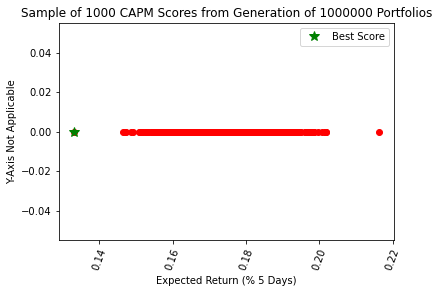

In [85]:
#Must be less than num_hypothetical_portfolios - 1
num_data_points = 1000
frequency = "5 Days"
scaler = 100 * numperiods

#Indexes for Sample of CAPM scores
index_for_graph = np.random.randint(0, (num_hypothetical_portfolios - 1), num_data_points)

#Initialize list with best score
capm_examples = [best_score * scaler]

#Grab 'num_data_points' data points to graph
for d in range(num_data_points):
    capm_examples.append(capm_scores[index_for_graph[d]] * scaler)

#We have 1d data, so all y values are 0
y_values = [0] * (num_data_points + 1)

# Plot the data, pinpoint best score
plt.scatter(capm_examples, y_values, color = 'r')
plt.plot(best_score * scaler, 0, marker = '*', color = 'g', ls = 'none', ms = 10, label = 'Best Score')

# Set axis and title
plt.title(f'Sample of {num_data_points} CAPM Scores from Generation of {num_hypothetical_portfolios} Portfolios')
plt.xlabel(f'Expected Return (% {frequency})')
plt.xticks(rotation = '70')
plt.ylabel('Y-Axis Not Applicable')

plt.legend(loc = 'best')

plt.show()

In [88]:
#Performance check
performance_check_start_date = '2022-11-07'
performance_check_end_date = '2022-11-11'

#Consumes weights, dataframe of prices, capital, start and end date, outputs return of portfolio between those dates, and expected fluctuation for reference.
def performance_check(weights, price_df, capital, start, end):
    values = []

    #Shares times ending prices
    for price in price_df.loc[:]:
        values.append(capital / price_df.loc[start, price] * price_df.loc[end, price])
    
    starting = capital
    ending = np.dot(values, weights)

    #Summary
    print(f"Return of portfolio from {start} to {end}: {np.round((ending - starting) / starting * 100, 2)}%.")
    print(f"Expected return for time period \"{frequency}\" for reference: {np.round(port_expected_return, 2)}%.")

performance_check(optimal_weighting, tickersPrice_final, capital, performance_check_start_date, performance_check_end_date)

Absolute fluctuation of portfolio from 2022-11-07 to 2022-11-11: 0.6%.
Expected fluctuation for time period "5 Days" for reference: 0.13%.


In [91]:
#Final dataframe, output to csv
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']]
Stocks_Final.to_csv("Stocks_Group_05.csv", encoding='utf-8')

In [92]:
#Final portfolio
Portfolio_Final

,Ticker,Price,Shares,Value,Weight
1,ABBV,157.110001,68.275146,10726.708207,0.021453
2,ABT,103.879997,138.364994,14373.355241,0.028747
3,BK,44.650002,316.584500,14135.498423,0.028271
4,BMY,78.959999,159.158973,12567.192358,0.025134
5,CL,76.919998,142.995188,10999.189569,0.021998
6,COST,523.369995,21.634352,11322.770455,0.022646
7,CSCO,47.619999,314.708242,14986.406134,0.029973
8,CVS,97.889999,209.590209,20516.785474,0.041034
9,KMI,18.280001,590.851035,10800.757321,0.021602
10,KO,62.080002,219.636338,13635.024264,0.027270


### Conclusion

### Sources
- *Weight Generation: https://stackoverflow.com/questions/74527506/creating-a-list-of-n-numbers-between-x-and-y-who-sum-up-to-z
- 

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Piero Camposeo, Sathun Suthakaran, Ishaan Bansal